# Librearies

In [242]:
# ---------------------------------- Tabular --------------------------------- #
import numpy as np
import pandas as pd

# -------------------------------- classifiers ------------------------------- #
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# ------------------------------- Scoring tools ------------------------------ #
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score

# ----------------------------------- tools ---------------------------------- #
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# -------------------------------- Displaying -------------------------------- #
from pprint import pprint
import matplotlib.pyplot as plt


# Shared tools

In [183]:
def score(y_train, y_pred_train, y_dev, y_pred_dev):
    print("For Training dataset : ")
    print("Accuracy : ", accuracy_score(y_train, y_pred_train))
    ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train)).plot()
    plt.show()

    print("For Dev set :")
    ConfusionMatrixDisplay(confusion_matrix(y_dev, y_pred_dev)).plot()
    print("Accuracy : ", accuracy_score(y_dev, y_pred_dev))
    plt.show()

# Import data

In [184]:
data = pd.read_csv("data/drinking_water_potability.csv", index_col= False)
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690300,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833605,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762125,8.114887,359.950170,481.792305,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


# Model by deleting missing values

## Remove Missing values and build dataset

In [185]:
data_dropped_na = pd.DataFrame(data[data.isna().sum(axis = 1)==0])
data_dropped_na.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000
mean,7.085990,195.968072,21917.441375,7.134338,333.224672,426.526409,14.357709,66.400859,3.969729,0.403282
std,1.573337,32.635085,8642.239815,1.584820,41.205172,80.712572,3.324959,16.077109,0.780346,0.490678
min,0.227499,73.492234,320.942611,1.390871,129.000000,201.619737,2.200000,8.577013,1.450000,0.000000
25%,6.089723,176.744938,15615.665390,6.138895,307.632511,366.680307,12.124105,55.952664,3.442915,0.000000
50%,7.027297,197.191839,20933.512750,7.143907,332.232177,423.455906,14.322019,66.542198,3.968177,0.000000
75%,8.052969,216.441070,27182.587065,8.109726,359.330555,482.373169,16.683049,77.291925,4.514175,1.000000
max,14.000000,317.338124,56488.672410,13.127000,481.030642,753.342620,27.006707,124.000000,6.494749,1.000000


In [195]:
training_columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity','Organic_carbon', 'Trihalomethanes', 'Turbidity']
predict_column = ['Potability']
X = data_dropped_na[training_columns]
Y = data_dropped_na[predict_column]

## Split train and dev

In [196]:
x_train, x_dev, y_train, y_dev = train_test_split(X, Y, test_size= 0.2)

## Adaboost

C:\Users\Mustapha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


For Training dataset : 
Accuracy :  0.9670398009950248


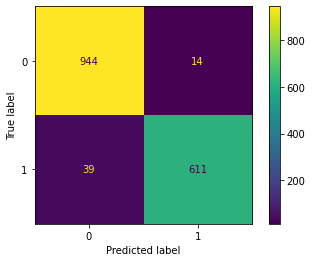

For Dev set :
Accuracy :  0.6203473945409429


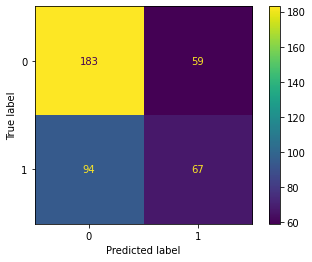

In [204]:
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3) ,n_estimators=60)

model.fit(x_train, y_train)

y_pred_train = model.predict(x_train)
y_pred_dev = model.predict(x_dev)

score(y_train, y_pred_train, y_dev, y_pred_dev)

## Random Forest

C:\Users\Mustapha\AppData\Local\Temp/ipykernel_19804/863954808.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


For Training dataset : 
Accuracy :  1.0


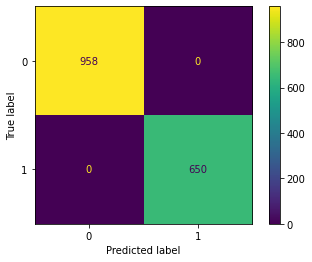

For Dev set :
Accuracy :  0.6972704714640199


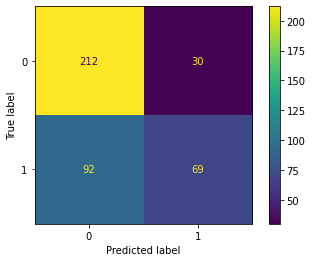

In [221]:
model = RandomForestClassifier(n_estimators=10000)

model.fit(x_train, y_train)

y_pred_train = model.predict(x_train)
y_pred_dev = model.predict(x_dev)

score(y_train, y_pred_train, y_dev, y_pred_dev)

## SVM

C:\Users\Mustapha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


For Training dataset : 
Accuracy :  1.0


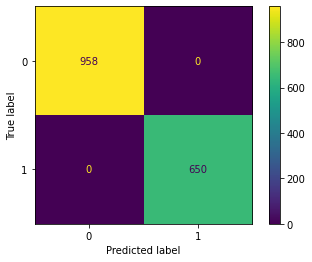

For Dev set :
Accuracy :  0.6253101736972705


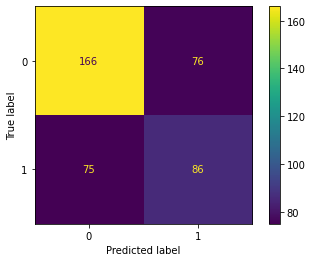

In [243]:
model = SVC(C=100000, kernel='rbf')
pipe = Pipeline([("Scaler", StandardScaler()), \
    ("SVM", model)])

pipe.fit(x_train, y_train)

y_pred_train = pipe.predict(x_train)
y_pred_dev = pipe.predict(x_dev)

score(y_train, y_pred_train, y_dev, y_pred_dev)

### Gradient Boosting

C:\Users\Mustapha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


For Training dataset : 
Accuracy :  0.9259950248756219


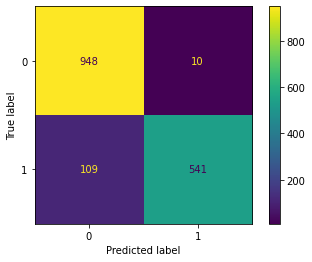

For Dev set :
Accuracy :  0.6674937965260546


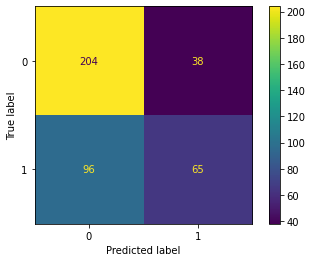

In [241]:
model = GradientBoostingClassifier(n_estimators=10000, learning_rate=0.003)

model.fit(x_train, y_train)

y_pred_train = model.predict(x_train)
y_pred_dev = model.predict(x_dev)

score(y_train, y_pred_train, y_dev, y_pred_dev)